In [1]:
import os
import sys
import pandas as pd
import numpy as np
from scipy import stats
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator, clone

PROJECT_PATH = os.path.join(os.getcwd(), '../')

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
    
from server.ml_models.all_model import AllModelData
from server.ml_models.match_model import CATEGORY_COLS
from server.ml_models import EnsembleModel
from server.ml_models.data_config import TEAM_NAMES, ROUND_TYPES, VENUES

from src.model.metrics import yearly_performance_scores
from src.model.charts import graph_yearly_model_performance

SEED = 42
N_ITER = 5
CV = 5

np.random.seed(SEED)

In [2]:
data = AllModelData(train_years=(None, 2015), test_years=(2016, 2016))
X_train, y_train = data.train_data()
X_train

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


team         oppo_team round_type  \
Adelaide         1991 1           Adelaide          Hawthorn    Regular   
                      2           Adelaide           Carlton    Regular   
                      3           Adelaide            Sydney    Regular   
                      4           Adelaide          Essendon    Regular   
                      5           Adelaide        West Coast    Regular   
                      6           Adelaide  Western Bulldogs    Regular   
                      7           Adelaide          St Kilda    Regular   
                      9           Adelaide   North Melbourne    Regular   
                      10          Adelaide         Melbourne    Regular   
                      11          Adelaide           Geelong    Regular   
                      12          Adelaide           Fitzroy    Regular   
                      13          Adelaide          Richmond    Regular   
                      14          Adelaide          Brisbane    Regular   
                      15          Adelaide       Collingwood    Regular   
                      16          Adelaide          Hawthorn    Regular   
                      17          Adelaide           Carlton    Regular   
                      18          Adelaide            Sydney    Regular   
                      19          Adelaide          Essendon    Regular   
                      20          Adelaide        West Coast    Regular   
                      21          Adelaide  Western Bulldogs    Regular   
                      22          Adelaide          St Kilda    Regular   
                      24          Adelaide   North Melbourne    Regular   
                 1992 1           Adelaide  Western Bulldogs    Regular   
                      3           Adelaide         Melbourne    Regular   
                      4           Adelaide           Fitzroy    Regular   
                      5           Adelaide          Richmond    Regular   
                      6           Adelaide          Brisbane    Regular   
                      7           Adelaide          St Kilda    Regular   
                      8           Adelaide           Geelong    Regular   
                      9           Adelaide       Collingwood    Regular   
...                                    ...               ...        ...   
Western Bulldogs 2014 17  Western Bulldogs        Gold Coast    Regular   
                      18  Western Bulldogs          Essendon    Regular   
                      19  Western Bulldogs          Hawthorn    Regular   
                      20  Western Bulldogs          St Kilda    Regular   
                      21  Western Bulldogs   North Melbourne    Regular   
                      22  Western Bulldogs            Sydney    Regular   
                      23  Western Bulldogs               GWS    Regular   
                 2015 1   Western Bulldogs        West Coast    Regular   
                      2   Western Bulldogs          Richmond    Regular   
                      3   Western Bulldogs          Hawthorn    Regular   
                      4   Western Bulldogs          Adelaide    Regular   
                      5   Western Bulldogs            Sydney    Regular   
                      6   Western Bulldogs          St Kilda    Regular   
                      7   Western Bulldogs         Fremantle    Regular   
                      8   Western Bulldogs         Melbourne    Regular   
                      9   Western Bulldogs               GWS    Regular   
                      10  Western Bulldogs     Port Adelaide    Regular   
                      12  Western Bulldogs          Brisbane    Regular   
                      13  Western Bulldogs          St Kilda    Regular   
                      14  Western Bulldogs           Carlton    Regular   
                      15  Western Bulldogs        Gold Coast    Regular   
                      16  Western Bulldogs           Geelong   

## Test performance with new features

In [3]:
model = EnsembleModel()
params = {
    'pipeline__baggingregressor__n_estimators': stats.randint(5, 15),
    'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'],
    'pipeline__baggingregressor__base_estimator__colsample_bylevel': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__colsample_bytree': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__learning_rate': stats.uniform(0.075, 0.05),
    'pipeline__baggingregressor__base_estimator__max_depth': stats.randint(2, 10),
    'pipeline__baggingregressor__base_estimator__n_estimators': stats.randint(75, 150),
    'pipeline__baggingregressor__base_estimator__reg_alpha': stats.uniform(0.0, 0.2),
    'pipeline__baggingregressor__base_estimator__reg_lambda': stats.uniform(0.75, 0.5),
    'pipeline__baggingregressor__base_estimator__subsample': stats.uniform(0.8, 0.2),
}

bag_cv = RandomizedSearchCV(model, params, scoring='neg_mean_absolute_error', n_jobs=1, cv=CV,
                            n_iter=N_ITER, random_state=SEED, verbose=1)

In [4]:
bag_cv.fit(*data.train_data())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 139.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=EnsembleModel(name='EnsembleModel',
       pipeline=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None,
         remainder=StandardScaler(copy=True, with_mean=True, with_std=True),
         sparse_threshold=0.3, transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None,
       categories=[['Ade...imators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])),
          fit_params=None, iid='warn', n_iter=5, n_jobs=1,
          param_distributions={'pipeline__baggingregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2e5e25b1d0>, 'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'], 'pipeline__baggingregressor__base_estimator__colsample_bylevel': <scipy.stat..._base_estimator__subsample': <scipy.stats._distn_infrastructure.

In [5]:
bag_cv.best_score_, bag_cv.refit_time_, bag_cv.best_params_

(-26.14405776807696,
 631.5626974105835,
 {'pipeline__baggingregressor__base_estimator__booster': 'gbtree',
  'pipeline__baggingregressor__base_estimator__colsample_bylevel': 0.8092900825439996,
  'pipeline__baggingregressor__base_estimator__colsample_bytree': 0.9215089703802877,
  'pipeline__baggingregressor__base_estimator__learning_rate': 0.08352620618436457,
  'pipeline__baggingregressor__base_estimator__max_depth': 8,
  'pipeline__baggingregressor__base_estimator__n_estimators': 92,
  'pipeline__baggingregressor__base_estimator__reg_alpha': 0.18977710745066667,
  'pipeline__baggingregressor__base_estimator__reg_lambda': 1.2328160165372797,
  'pipeline__baggingregressor__base_estimator__subsample': 0.9616794696232923,
  'pipeline__baggingregressor__n_estimators': 13})

In [7]:
data.train_years = (None, 2016)
X_train, y_train = data.train_data()

scores = yearly_performance_scores([('ensemble', model, {})], X_train, y_train, data_frame=True, parallel=False)

scores

Getting scores for 2011
	Getting scores for ensemble
Getting scores for 2012
	Getting scores for ensemble
Getting scores for 2013
	Getting scores for ensemble
Getting scores for 2014
	Getting scores for ensemble
Getting scores for 2015
	Getting scores for ensemble
Getting scores for 2016
	Getting scores for ensemble


,accuracy,error,model,year
0,0.778061,29.714675,ensemble,2011
1,0.809179,27.735926,ensemble,2012
2,0.748792,27.002570,ensemble,2013
3,0.739130,28.601392,ensemble,2014
4,0.728155,30.142726,ensemble,2015
5,0.714976,28.142741,ensemble,2016


In [8]:
scores.groupby('model').mean()[['error', 'accuracy']]

,error,accuracy
model,,
ensemble,28.556672,0.753049


### Performance is in the middle of prior models
It's better than the first version of the ensemble model, but a mixed compared to the model with just the `elo_rating` feature added (higher accuracy & error).

## Reduce features via correlation with labels
I had pretty good results using this when I had far fewer features, reducing from 76 to 18 with an increase in error of 0.16. Also, it's faster than PCA or `feature_importance` methods, because it doesn't require an extra model-training step in the pipeline.

In [9]:
data.train_years = (None, 2015)
X_train, y_train = data.train_data()
X_train['margin'] = y_train

correlations = X_train.corr().fillna(0)['margin'].abs().sort_values(ascending=False)
correlations

margin                                                 1.000000
elo_pred_win                                           0.417837
oppo_elo_rating                                        0.343918
elo_rating                                             0.343751
oppo_rolling_mean_margin_by_venue                      0.336591
rolling_mean_margin_by_venue                           0.336456
oppo_rolling_mean_margin_by_oppo_team                  0.331398
rolling_mean_margin_by_oppo_team                       0.331398
oppo_rolling_prev_match_result_rate                    0.328252
rolling_prev_match_result_rate                         0.327986
rolling_elo_pred_win_rate                              0.327231
oppo_rolling_mean_result_by_venue                      0.312962
rolling_mean_result_by_venue                           0.312915
oppo_rolling_mean_result_by_oppo_team                  0.283482
rolling_mean_result_by_oppo_team                       0.283475
oppo_ladder_position                    

In [24]:
threshold_min = 0.001
threshold_max = 0.05
threshold_best = 0.038121046704238715

print(f'threshold={threshold_min}')
print(f'Feature count:', sum(correlations > threshold_min))
print(f'% feature sample:', sum(correlations > threshold_min) / len(correlations))
print()
print(f'threshold={threshold_max}')
print(f'Feature count:', sum(correlations > threshold_max))
print(f'% feature sample:', sum(correlations > threshold_max) / len(correlations))
print()
print(f'threshold={threshold_best}')
print(f'Feature count:', sum(correlations > threshold_best))
print(f'% feature sample:', sum(correlations > threshold_best) / len(correlations))

threshold=0.001
Feature count: 256
% feature sample: 0.927536231884058

threshold=0.05
Feature count: 60
% feature sample: 0.21739130434782608

threshold=0.038121046704238715
Feature count: 72
% feature sample: 0.2608695652173913


In [11]:
class CorrelationChooser(TransformerMixin, BaseEstimator):
    def __init__(self, labels, cols_to_keep=[], threshold=None):
        self.labels = labels
        self.threshold = threshold
        self.cols_to_keep = cols_to_keep
        self._cols_to_keep = self.cols_to_keep

    def transform(self, X):
        return X[self._cols_to_keep]

    def fit(self, X, *_):
        df = pd.concat([X, self.labels], axis=1).drop(self.cols_to_keep, axis=1)
        self._cols_to_keep = df.columns[df.corr().fillna(0)[df.columns[-1]].abs() > self.threshold]
        self._cols_to_keep = self.cols_to_keep + [col for col in self._cols_to_keep if col in X.columns]

        return self


reduced_model = clone(model)
reduced_model.pipeline.steps = [
    (
        "correlationchooser",
        CorrelationChooser(
            y_train,
            threshold=0.1,
            cols_to_keep=["team", "oppo_team", "round_type", "venue"],
        ),
    )
] + reduced_model.pipeline.steps

reduced_params = {
    'pipeline__correlationchooser__threshold': stats.uniform(0.025, 0.024),
    'pipeline__baggingregressor__n_estimators': stats.randint(5, 15),
    'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'],
    'pipeline__baggingregressor__base_estimator__colsample_bylevel': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__colsample_bytree': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__learning_rate': stats.uniform(0.075, 0.05),
    'pipeline__baggingregressor__base_estimator__max_depth': stats.randint(2, 10),
    'pipeline__baggingregressor__base_estimator__n_estimators': stats.randint(75, 150),
    'pipeline__baggingregressor__base_estimator__reg_alpha': stats.uniform(0.0, 0.2),
    'pipeline__baggingregressor__base_estimator__reg_lambda': stats.uniform(0.75, 0.5),
    'pipeline__baggingregressor__base_estimator__subsample': stats.uniform(0.8, 0.2),
}

reduced_cv = RandomizedSearchCV(reduced_model, reduced_params, scoring='neg_mean_absolute_error', n_jobs=1, cv=CV,
                            n_iter=N_ITER, random_state=SEED, verbose=1)

In [12]:
reduced_cv.fit(X_train.drop('margin', axis=1), y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 93.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=EnsembleModel(name='EnsembleModel',
       pipeline=Pipeline(memory=None,
     steps=[('correlationchooser', CorrelationChooser(cols_to_keep=['team', 'oppo_team', 'round_type', 'venue'],
          labels=Adelaide          1991  1      86
                        2     -23
                        3      24
                        4     -45
                        5     -65
     ...imators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])),
          fit_params=None, iid='warn', n_iter=5, n_jobs=1,
          param_distributions={'pipeline__correlationchooser__threshold': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2e31bc51d0>, 'pipeline__baggingregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2e31bc5b00>, 'pipeline__baggingregressor__base_estimator__boo..._base_estimator__subsample': <scipy.stats._distn_infrastructure.

In [13]:
reduced_cv.best_score_, reduced_cv.refit_time_, reduced_cv.best_params_

(-26.213106905317495,
 230.013418674469,
 {'pipeline__baggingregressor__base_estimator__booster': 'dart',
  'pipeline__baggingregressor__base_estimator__colsample_bylevel': 0.9366527037650917,
  'pipeline__baggingregressor__base_estimator__colsample_bytree': 0.9219993315565242,
  'pipeline__baggingregressor__base_estimator__learning_rate': 0.11665974558680822,
  'pipeline__baggingregressor__base_estimator__max_depth': 4,
  'pipeline__baggingregressor__base_estimator__n_estimators': 110,
  'pipeline__baggingregressor__base_estimator__reg_alpha': 0.03644721755761247,
  'pipeline__baggingregressor__base_estimator__reg_lambda': 1.1276807051588262,
  'pipeline__baggingregressor__base_estimator__subsample': 0.885031174898249,
  'pipeline__baggingregressor__n_estimators': 10,
  'pipeline__correlationchooser__threshold': 0.038121046704238715})

## Reduce features with feature_importances_

In [14]:
X_train, y_train = data.train_data()
X_train_numeric = X_train.drop(['team', 'oppo_team', 'round_type', 'venue'], axis=1)
dt = DecisionTreeRegressor()
dt.fit(X_train_numeric, y_train)

feature_importances = (
    pd.Series(dt.feature_importances_, index=X_train_numeric.columns.values).sort_values(ascending=False)
)
feature_importances

elo_pred_win                                           1.745286e-01
elo_rating                                             5.884324e-02
oppo_elo_rating                                        5.793382e-02
at_home                                                4.322725e-02
rolling_mean_margin_by_venue                           1.456982e-02
prev_match_margin                                      1.322316e-02
oppo_prev_match_oppo_score                             1.279145e-02
oppo_prev_match_margin                                 1.271961e-02
oppo_rolling_mean_score_by_venue                       1.252893e-02
cum_percent                                            1.221716e-02
oppo_rolling_mean_margin_by_venue                      1.214072e-02
rolling_mean_score_by_oppo_team                        1.202984e-02
elo_rating_divided_by_ladder_position                  1.170429e-02
rolling_mean_score_by_venue                            1.135350e-02
oppo_cum_percent                                

In [27]:
threshold_min = 0.0001
threshold_max = 0.0035
threshold_best = 0.0027294074748835753

print(f'threshold={threshold_min}')
print(f'Feature count:', sum(feature_importances > threshold_min))
print(f'% feature sample:', sum(feature_importances > threshold_min) / len(feature_importances))
print()
print(f'threshold={threshold_max}')
print(f'Feature count:', sum(feature_importances > threshold_max))
print(f'% feature sample:', sum(feature_importances > threshold_max) / len(feature_importances))
print()
print(f'threshold={threshold_best}')
print(f'Feature count:', sum(feature_importances > threshold_best))
print(f'% feature sample:', sum(feature_importances > threshold_best) / len(feature_importances))

threshold=0.0001
Feature count: 258
% feature sample: 0.9381818181818182

threshold=0.0035
Feature count: 68
% feature sample: 0.24727272727272728

threshold=0.0027294074748835753
Feature count: 88
% feature sample: 0.32


In [16]:
X_train, y_train = data.train_data()

class ImportanceChooser(TransformerMixin, BaseEstimator):
    def __init__(self, labels, cols_to_keep=[], threshold=None, model=DecisionTreeRegressor()):
        self.labels = labels
        self.threshold = threshold
        self.cols_to_keep = cols_to_keep
        self._cols_to_keep = self.cols_to_keep
        self.model = model

    def transform(self, X):
        return X[self._cols_to_keep]

    def fit(self, X, *_):
        _X = X.drop(self.cols_to_keep, axis=1)
        _y = self.labels.loc[_X.index]
        self.model.fit(_X, _y)
        feature_importances = pd.Series(dt.feature_importances_, index=_X.columns.values)
        self._cols_to_keep = feature_importances[feature_importances > self.threshold].index.values
        self._cols_to_keep = self.cols_to_keep + [col for col in self._cols_to_keep if col in X.columns]

        return self


import_model = clone(model)
import_model.pipeline.steps = [
    (
        "importancechooser",
        ImportanceChooser(
            y_train,
            threshold=0.0001,
            cols_to_keep=["team", "oppo_team", "round_type", "venue"],
        ),
    )
] + import_model.pipeline.steps

import_params = {
    'pipeline__importancechooser__threshold': stats.uniform(0.0018, 0.0017),
    'pipeline__baggingregressor__n_estimators': stats.randint(5, 15),
    'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'],
    'pipeline__baggingregressor__base_estimator__colsample_bylevel': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__colsample_bytree': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__learning_rate': stats.uniform(0.075, 0.05),
    'pipeline__baggingregressor__base_estimator__max_depth': stats.randint(2, 10),
    'pipeline__baggingregressor__base_estimator__n_estimators': stats.randint(75, 150),
    'pipeline__baggingregressor__base_estimator__reg_alpha': stats.uniform(0.0, 0.2),
    'pipeline__baggingregressor__base_estimator__reg_lambda': stats.uniform(0.75, 0.5),
    'pipeline__baggingregressor__base_estimator__subsample': stats.uniform(0.8, 0.2),
}

import_cv = RandomizedSearchCV(import_model, import_params, scoring='neg_mean_absolute_error', n_jobs=1, cv=CV,
                            n_iter=N_ITER, random_state=SEED, verbose=1)

In [17]:
import_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 103.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=EnsembleModel(name='EnsembleModel',
       pipeline=Pipeline(memory=None,
     steps=[('importancechooser', ImportanceChooser(cols_to_keep=['team', 'oppo_team', 'round_type', 'venue'],
         labels=Adelaide          1991  1      86
                        2     -23
                        3      24
                        4     -45
                        5     -65
        ...imators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])),
          fit_params=None, iid='warn', n_iter=5, n_jobs=1,
          param_distributions={'pipeline__importancechooser__threshold': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2e31eda2b0>, 'pipeline__baggingregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2e31f0ca58>, 'pipeline__baggingregressor__base_estimator__boos..._base_estimator__subsample': <scipy.stats._distn_infrastructure.

In [18]:
import_cv.best_score_, import_cv.refit_time_, import_cv.best_params_

(-26.197017890442787,
 236.1412169933319,
 {'pipeline__baggingregressor__base_estimator__booster': 'dart',
  'pipeline__baggingregressor__base_estimator__colsample_bylevel': 0.9366527037650917,
  'pipeline__baggingregressor__base_estimator__colsample_bytree': 0.9219993315565242,
  'pipeline__baggingregressor__base_estimator__learning_rate': 0.11665974558680822,
  'pipeline__baggingregressor__base_estimator__max_depth': 4,
  'pipeline__baggingregressor__base_estimator__n_estimators': 110,
  'pipeline__baggingregressor__base_estimator__reg_alpha': 0.03644721755761247,
  'pipeline__baggingregressor__base_estimator__reg_lambda': 1.1276807051588262,
  'pipeline__baggingregressor__base_estimator__subsample': 0.885031174898249,
  'pipeline__baggingregressor__n_estimators': 10,
  'pipeline__importancechooser__threshold': 0.0027294074748835753})

### Dimension reduction with PCA

In [19]:
X_train, y_train = data.train_data()

pca = PCA()
pca.fit_transform(pd.get_dummies(X_train))
np.cumsum(pca.explained_variance_ratio_)

array([0.53940284, 0.7627946 , 0.92145995, 0.96395893, 0.97839487,
       0.9882305 , 0.99067582, 0.99252842, 0.99391667, 0.99501426,
       0.99598005, 0.99654395, 0.9970726 , 0.99745257, 0.99779115,
       0.9981143 , 0.99838578, 0.9986296 , 0.99884812, 0.99898244,
       0.99909851, 0.99919674, 0.99927473, 0.99934678, 0.99941449,
       0.99947463, 0.99953331, 0.99958556, 0.99963635, 0.99967365,
       0.99971067, 0.99974107, 0.99977002, 0.99979392, 0.99981731,
       0.99983461, 0.99985017, 0.99986456, 0.99987434, 0.99988384,
       0.99989281, 0.99990162, 0.99990878, 0.999915  , 0.99992034,
       0.99992556, 0.99993057, 0.99993467, 0.99993855, 0.99994239,
       0.99994605, 0.99994971, 0.99995271, 0.99995564, 0.99995791,
       0.99996011, 0.99996202, 0.99996392, 0.99996574, 0.9999675 ,
       0.99996919, 0.99997076, 0.99997226, 0.99997367, 0.99997496,
       0.99997624, 0.9999774 , 0.99997855, 0.99997965, 0.99998065,
       0.99998163, 0.99998255, 0.99998343, 0.99998428, 0.99998

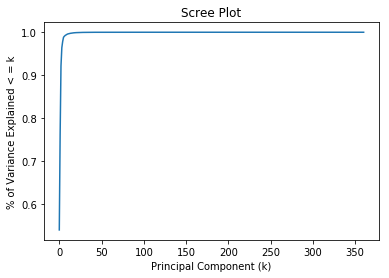

In [20]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Scree Plot')
plt.xlabel('Principal Component (k)')
plt.ylabel('% of Variance Explained < = k')
None

In [21]:
n_features = len(X_train.columns)

pca_model = clone(model)
pca_model.pipeline.steps = [
    (
        'columntransformer',
         ColumnTransformer(
            [
                (
                    "onehotencoder",
                    OneHotEncoder(
                        categories=[TEAM_NAMES, TEAM_NAMES, ROUND_TYPES, VENUES], sparse=False
                    ),
                    list(range(4)),
                ),
            ],
            remainder=PCA(),
        ),
    ),
] + pca_model.pipeline.steps[1:]

pca_params = {
    'pipeline__columntransformer__remainder__n_components': stats.randint(7, n_features - 1),
    'pipeline__baggingregressor__n_estimators': stats.randint(5, 15),
    'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'],
    'pipeline__baggingregressor__base_estimator__colsample_bylevel': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__colsample_bytree': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__learning_rate': stats.uniform(0.075, 0.05),
    'pipeline__baggingregressor__base_estimator__max_depth': stats.randint(2, 10),
    'pipeline__baggingregressor__base_estimator__n_estimators': stats.randint(75, 150),
    'pipeline__baggingregressor__base_estimator__reg_alpha': stats.uniform(0.0, 0.2),
    'pipeline__baggingregressor__base_estimator__reg_lambda': stats.uniform(0.75, 0.5),
    'pipeline__baggingregressor__base_estimator__subsample': stats.uniform(0.8, 0.2),
}

pca_cv = RandomizedSearchCV(pca_model, pca_params, scoring='neg_mean_absolute_error', n_jobs=1, cv=CV,
                            n_iter=N_ITER, random_state=SEED, verbose=1)

In [22]:
pca_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 204.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=EnsembleModel(name='EnsembleModel',
       pipeline=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None,
         remainder=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
         sparse_threshold=0.3, transformer_weights=None,
         transformers=[('onehotencoder', On...imators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])),
          fit_params=None, iid='warn', n_iter=5, n_jobs=1,
          param_distributions={'pipeline__columntransformer__remainder__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2e326d6978>, 'pipeline__baggingregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2e326d6c88>, 'pipeline__baggingregressor__base_e..._base_estimator__subsample': <scipy.stats._distn_infrastructure.

In [23]:
pca_cv.best_score_, pca_cv.refit_time_, pca_cv.best_params_

(-26.558629085115946,
 669.7380964756012,
 {'pipeline__baggingregressor__base_estimator__booster': 'dart',
  'pipeline__baggingregressor__base_estimator__colsample_bylevel': 0.9593085973720467,
  'pipeline__baggingregressor__base_estimator__colsample_bytree': 0.8366869579732328,
  'pipeline__baggingregressor__base_estimator__learning_rate': 0.11398455001363847,
  'pipeline__baggingregressor__base_estimator__max_depth': 6,
  'pipeline__baggingregressor__base_estimator__n_estimators': 149,
  'pipeline__baggingregressor__base_estimator__reg_alpha': 0.09184977839317343,
  'pipeline__baggingregressor__base_estimator__reg_lambda': 0.9168543055695109,
  'pipeline__baggingregressor__base_estimator__subsample': 0.8285733635843882,
  'pipeline__baggingregressor__n_estimators': 7,
  'pipeline__columntransformer__remainder__n_components': 156})